# **Exploration of Exoplanets and Solar System Planets!**

*Author: Anton Zaitsev*  
*Date: December 21, 2023*

---------

# Data References

## NASA Exoplanet Archive

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

NASA Exoplanet Archive dataset contains information on confirmed planets outside of the Solar System, e.g. planet mass, radius, planet discovery method, orbital period, etc.

Rows: 35131
Columns: 286

## Solar System Major Bodies Data

https://www.kaggle.com/datasets/jaredsavage/solar-system-major-bodies-data

The Solar System Planets dataset contains information on major bodies inside the Solar System, including planets, such as Earth, Mars, Venus, etc. It includes information on body's attributes, such as mass, density, etc.

Rows: 31
Columns: 265

## Kepler Confirmed Planets

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=kep_conf_names

The Kepler Confirmed Planets dataset includes information about exoplanets that have been confirmed through observations by NASA's Kepler mission. Kepler-confirmed planets are those KOIs that have undergone further scrutiny and have been confirmed as actual exoplanets through additional observations. The confirmation process aims to rule out false positives and confirm that the observed signals are consistent with the presence of planets.

Rows: 2807
Columns: 4

## Equilibrium Temperatures for Solar Planets

http://astro.vaporia.com/start/equilibriumtemperature.html

This reference contains data (table) for equilibrium temperatures for planets inside the Solar System.

## The Distances from the Solar Planets to the Earth

https://promenade.imcce.fr/en/pages5/573.html

This reference contains data (table) for the distances for planets inside the Solar System to Earth.

## Habitable Zone Boudaries Calculation

https://www.planetarybiology.com/calculating_habitable_zone.html

We used this reference for the formula on how to calculate star inner and outer habitable zone boundaries.

## Solar System Habitable Zone Boundaries

https://www.britannica.com/science/habitable-zone

This article provides information on the habitable zone of the Sun.

## Sun Fact Sheet

https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html

This page contains data on Sun.

## Sun Age

https://ui.adsabs.harvard.edu/abs/1989ApJ...339.1156G/abstract#:~:text=The%20age%20of%20the%20sun,4.49%20%2B%20or%20%2D%200.04%20Gyr.

This page contains information about approximate Sun age.

---------



In [401]:
# Imports

import warnings
warnings.simplefilter('ignore', category=UserWarning)

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from ast import literal_eval

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.animation import FuncAnimation

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

In [400]:
# Global Variables
EXOPLANETS_PATH = 'data/exoplanets.csv'
EXOPLANETS_HEADER = 290
SOLARPLANETS_URL = 'data/solarplanets.csv'
KEPLER_PATH = 'data/kepler.csv'
KEPLER_HEADER = 8
PLOTS_SAVE_DIR = 'plots/'

COLORS = [
    '#BCE6DA', '#6EB4CD', '#3680D0', '#445792', '#433E7D', '#3F2B5C', 
    '#612F55', '#B13D54', '#CC4F4C', '#E66143', '#F3995D', '#FED2AA'
]
PRIMARY_COLOR_START = '#49B0D5'
PRIMARY_COLOR_MIDDLE = '#742963'
PRIMARY_COLOR_END = '#C63331'
COLOR_PALETTE = sns.color_palette(COLORS, 12)
COLOR_CMAP = ListedColormap(COLORS)

TITLE_SIZE = 16
SUBTITLE_SIZE = 14
AXIS_TITLE_SIZE = 12

In [65]:
## Exoplanets
descriptions = pd.read_csv(EXOPLANETS_PATH, nrows=EXOPLANETS_HEADER - 1)[2:-1].iloc[:, 0].tolist()
column_descriptions = {}
for item in descriptions:
    parts = item.split(':')
    if len(parts) == 2:
        key = parts[0].strip().split()[-1]
        value = parts[1].strip()
        column_descriptions[key] = value

columns_considered = [
    'pl_name', 'hostname', 'disc_year', 'discoverymethod', 
    'pl_controv_flag', 'sy_snum', 'sy_pnum', 'sy_mnum',
    'pl_orbper', 'pl_orbsmax', 
    'pl_rade', 'pl_masse', 'pl_dens',
    'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl',
    'st_teff', 'st_rad', 'st_mass', 'st_lum', 
    'st_logg', 'st_age', 'st_dens', 'st_vsin',
    'sy_dist', 'ra', 'dec'
]
exoplanets_dirty = pd.read_csv(EXOPLANETS_PATH, header=EXOPLANETS_HEADER, usecols=columns_considered, index_col=None)

columns_group = ['pl_name', 'hostname', 'disc_year', 'discoverymethod']
exoplanets = exoplanets_dirty.groupby(columns_group).mean()
exoplanets = exoplanets.reset_index()

exoplanets['sy_dist_log'] = np.log10(exoplanets['sy_dist'])


In [66]:
## Kepler Planets
keplerplanets = pd.read_csv(KEPLER_PATH, header=KEPLER_HEADER, index_col=None)

In [67]:
### Join Exoplanets and Kepler Confirmed Planets
exoplanets = exoplanets.copy() 
exoplanets['kepler_confirmed'] = exoplanets['pl_name'].isin(keplerplanets['pl_name'])
exoplanets['kepler_confirmed'] = exoplanets['kepler_confirmed'].astype(bool)

In [68]:
## Solar Planets
solar_bodies = pd.read_csv(SOLARPLANETS_URL)
solarplanets_names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
solarplanets = solar_bodies[solar_bodies['eName'].isin(solarplanets_names)].reset_index()
solarplanets['pl_eqt'] = [64, 51, 122, 226, 449, 90, 279, 328]
au_parcec = 206265
solarplanets['earth_dist_avg'] = [
    (17.292 + 21.089)/au_parcec,
    (28.817 + 31.317)/au_parcec,
    (3.957 + 6.454)/au_parcec,
    (0.372 + 2.671)/au_parcec,
    (0.552 + 1.446)/au_parcec,
    (8.050 + 11.046)/au_parcec,
    0/au_parcec,
    (0.266 + 1.736)/au_parcec
]
solarplanets['st_mass'] = 1

# convert features to earth scale
earth_mass = solarplanets.loc[solarplanets['eName'] == 'Earth', 'mass_kg'].values[0]
earth_radius = solarplanets.loc[solarplanets['eName'] == 'Earth', 'meanRadius'].values[0]
solarplanets['mass_earth'] = solarplanets['mass_kg'] / earth_mass
solarplanets['radius_earth'] = solarplanets['meanRadius'] / earth_radius

# rename column to match with exoplanets
solarplanets_rename_cols = {
    'mass_earth': 'pl_masse', 'sideralOrbit': 'pl_orbper', 
    'semimajorAxis_AU': 'pl_orbsmax', 'radius_earth': 'pl_rade', 
    'pl_eqt': 'pl_eqt', 'eName': 'pl_name', 'earth_dist_avg': 'sy_dist',
    'eccentricity': 'pl_orbeccen'}
solarplanets.rename(columns=solarplanets_rename_cols, inplace=True)

# define earth and solarplanets data separately
earth = solarplanets[solarplanets['pl_name'] == 'Earth']

In [69]:
# Data for Animation
animation_cols= ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_eqt', 'pl_name', 'sy_dist']
exoplanets_animation = exoplanets[animation_cols]
solarplanets_animation = solarplanets[animation_cols]
earth_animation = earth[animation_cols]
solar_exo_animation = pd.concat([exoplanets_animation, solarplanets_animation, earth_animation], ignore_index=True)
solar_exo_animation = solar_exo_animation.dropna(subset=['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_eqt', 'sy_dist'])

# Exploratory Analysis

> - An astronomical unit (AU) is a unit of measurement equal to the average distance between a planet and its host star.
>   - 1 AU is the average distance from the Earth to the Sun.
>   - 1 AU = 1.5 x 10^8 KM (150 million kilometers)
>   - 1 Parsec = 206,265 AU
>   - 1 Parsec = 3.09 x 10^13 KM

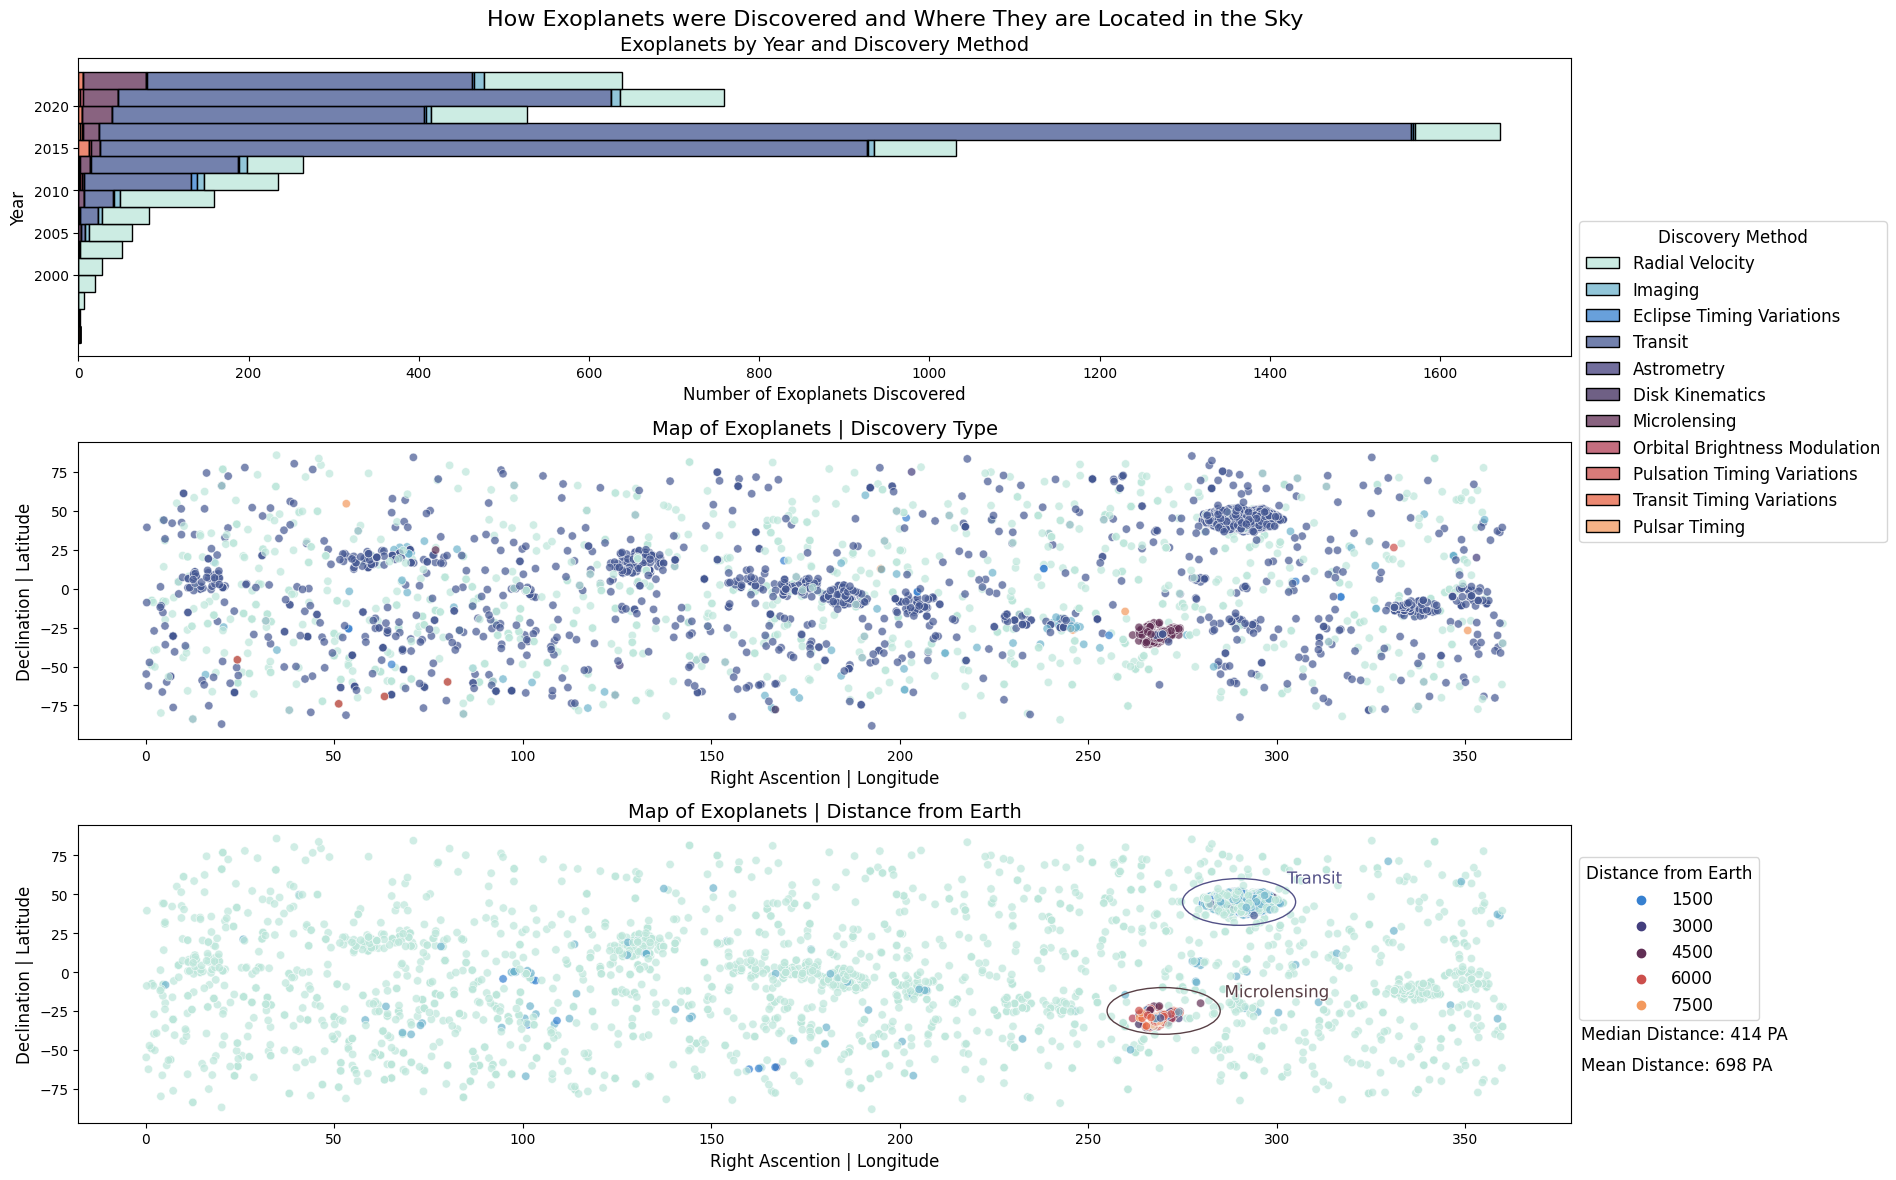

In [178]:
## Discovery Method & Location in Sky
fig = plt.figure(figsize=(18, 12))
gridspan = fig.add_gridspec(3, 1)
fig.suptitle("How Exoplanets were Discovered and Where They are Located in the Sky", fontsize=TITLE_SIZE)
 
ax1 = fig.add_subplot(gridspan[0, :])
ax2 = fig.add_subplot(gridspan[1, :])
ax3 = fig.add_subplot(gridspan[2, :])

ax1_legend = sns.histplot(
    data=exoplanets, 
    y='disc_year', 
    multiple="stack",
    binwidth=2, 
    hue='discoverymethod', 
    palette=COLOR_PALETTE,
    ax=ax1
).get_legend()
ax1.set_title('Exoplanets by Year and Discovery Method', fontsize=SUBTITLE_SIZE)
ax1.set_xlabel('Number of Exoplanets Discovered',fontsize=AXIS_TITLE_SIZE)
ax1.set_ylabel('Year',fontsize=AXIS_TITLE_SIZE)
ax1.set_yticks(range(2000, max(exoplanets['disc_year'])+1, 5))

sns.scatterplot(
    x='ra', 
    y='dec', 
    hue='discoverymethod', 
    palette=COLOR_PALETTE,
    data=exoplanets, 
    alpha=0.7, 
    ax=ax2
)
ax2.set_title("Map of Exoplanets | Discovery Type", fontsize=SUBTITLE_SIZE)
ax2.set_xlabel("Right Ascention | Longitude", fontsize=AXIS_TITLE_SIZE)
ax2.set_ylabel("Declination | Latitude", fontsize=AXIS_TITLE_SIZE)

ax3_legend = sns.scatterplot(
    x='ra', 
    y='dec', 
    hue='sy_dist', 
    palette=COLOR_CMAP,
    data=exoplanets, 
    alpha=0.7, 
    ax=ax3
).get_legend()
ax3.set_title("Map of Exoplanets | Distance from Earth", fontsize=SUBTITLE_SIZE)
ax3.set_xlabel("Right Ascention | Longitude", fontsize=AXIS_TITLE_SIZE)
ax3.set_ylabel("Declination | Latitude", fontsize=AXIS_TITLE_SIZE)

transit_circle_center = (290, 45)
transit_circle_radius = 15
transit_circle = plt.Circle(transit_circle_center, transit_circle_radius, fill=False, color='#535187')
microlensing_circle_center = (270, -25)
microlensing_circle_radius = 15
microlensing_circle = plt.Circle(microlensing_circle_center, microlensing_circle_radius, fill=False, color='#594046')
ax3.add_patch(transit_circle)
ax3.add_patch(microlensing_circle)
ax3.text(310, 60, 'Transit', ha='center', va='center', color='#535187', fontsize=12, path_effects=[pe.withStroke(linewidth=1, foreground="white")])
ax3.text(300, -13, 'Microlensing', ha='center', va='center', color='#594046', fontsize=12, path_effects=[pe.withStroke(linewidth=1, foreground="white")])

exo_dist_med = int(exoplanets['sy_dist'].median())
exo_dist_mean = int(exoplanets['sy_dist'].mean())
ax3.text(408, -40, f"Median Distance: {exo_dist_med} PA", ha='center', va='center', color='black', fontsize=12)
ax3.text(406, -60, f"Mean Distance: {exo_dist_mean} PA", ha='center', va='center', color='black', fontsize=12)

handles1, labels1 = ax1_legend.legendHandles, [text.get_text() for text in ax1_legend.get_texts()]
handles3, labels3 = ax3_legend.legendHandles, [text.get_text() for text in ax3_legend.get_texts()]
fig.legend_ = None
fig.legend(handles=handles1, labels=labels1, title='Discovery Method', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.8755, 0.81), loc='upper left')
fig.legend(handles=handles3, labels=labels3, title='Distance from Earth', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.8755, 0.28), loc='upper left')
ax1.legend([]).set_visible(False)
ax2.legend([]).set_visible(False)
ax3.legend([]).set_visible(False)

plt.tight_layout()
plt.savefig(f"{PLOTS_SAVE_DIR}distribution", bbox_inches='tight')
plt.show()

## Distribution Analysis of Exoplanetary Parameters, including Earth Comparison

Here, we will explore statistical distributions of various exoplanetary parameters and compare these values with analogous parameter values observed on Earth.

> - **Planetary radius** refers to the average distance from the center to the outer boundary of a celestial body, such as a planet, providing a measure of its size.
> - **Orbital period** is the time it takes for a celestial object, such as a planet, to complete one full revolution around its host star or a central point in its orbit.
> - **Orbital distance** is the measure of how far a planet is from its hosting star.
> - **Equilibrium Temperature** is an estimate of the temperature a planet or celestial body would have if it were a simple black body, thus not subject to atmospheric windows, internal heat sources, etc.
>   - Does not count the **greenhouse effect** !
> - Some Earth data for reference:
    >   - Earth radius = 6.371 x 10^3 km
    >   - Earth mass = 5.972 x 10^24 kg
    >   - Earth orbital distance = 1 AU
    >   - Earth's Equilibrium Temperature: ≈ 255K = -18C

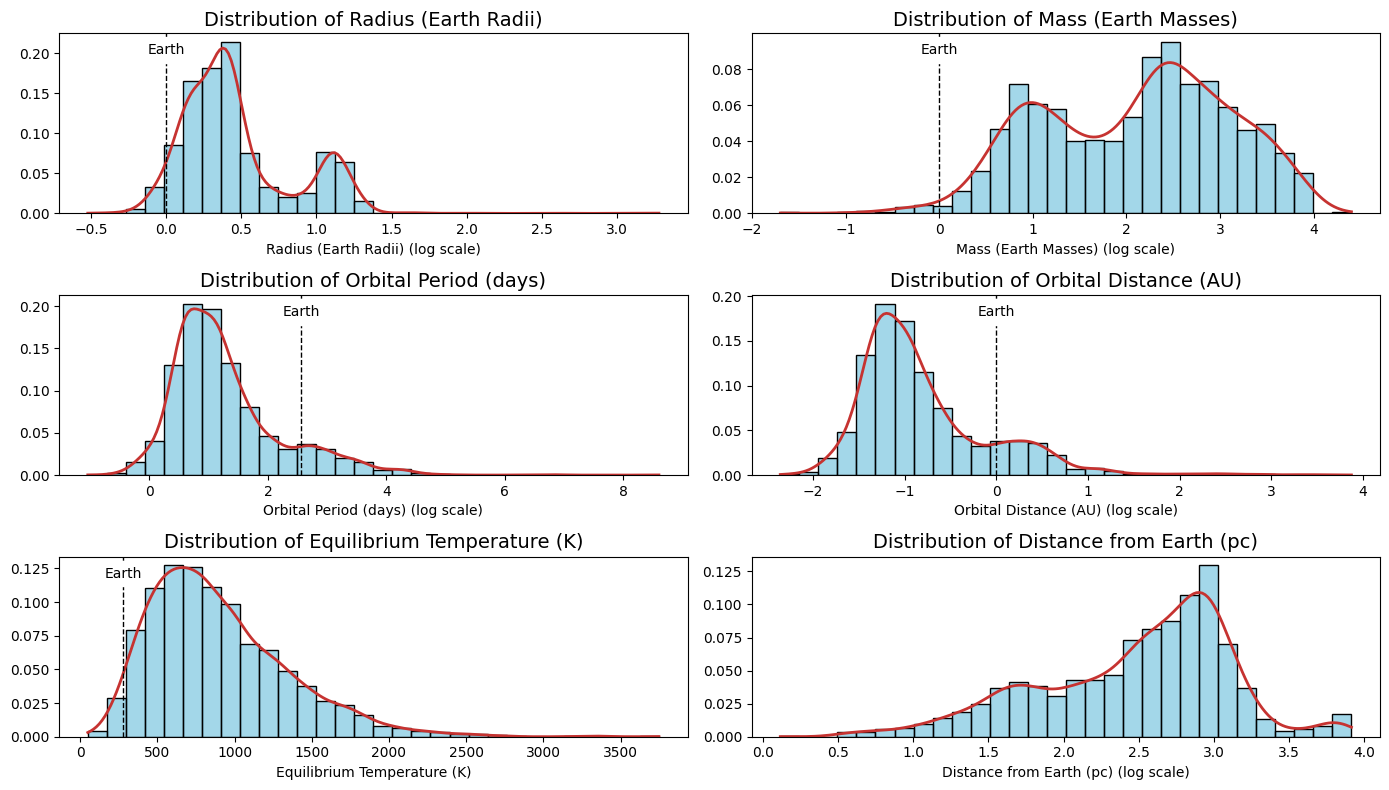

In [181]:
column_mapping = {
    'pl_rade': 'Radius (Earth Radii)',
    'pl_masse': 'Mass (Earth Masses)',
    'pl_orbper': 'Orbital Period (days)',
    'pl_orbsmax': 'Orbital Distance (AU)',
    'pl_eqt': 'Equilibrium Temperature (K)',
    'sy_dist': 'Distance from Earth (pc)',
}
columns_to_plot = list(column_mapping.keys())

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    data = exoplanets[column] if column == 'pl_eqt' else np.log10(exoplanets[column])
    hist = sns.histplot(x=data, bins=30, stat='probability', kde=True, color=PRIMARY_COLOR_START, line_kws={'lw': 2}, ax=axes[i])
    hist.lines[0].set_color(PRIMARY_COLOR_END)
    
    if (column != 'sy_dist'):
        earth_distance = earth[column].iloc[0] if column == 'pl_eqt' else np.log10(earth[column].iloc[0])
        axes[i].axvline(earth_distance, color='black', linestyle='--', label='Earth', linewidth=1)
        axes[i].text(earth_distance, axes[i].get_ylim()[1]*6.5/7.5, 'Earth', color='black', va='bottom', ha='center', backgroundcolor='white', fontsize=10)

    if column == 'pl_eqt':
        axes[i].set_xlabel(f'{column_mapping[column]}')
    else:
        axes[i].set_xlabel(f'{column_mapping[column]} (log scale)')
    axes[i].set_ylabel('')
    axes[i].set_title(f'Distribution of {column_mapping[column]}', fontsize=SUBTITLE_SIZE)

plt.tight_layout()
plt.savefig(f"{PLOTS_SAVE_DIR}distribution", bbox_inches='tight')
plt.show()

# Orbital Period - Animation

In [41]:
## Define Data for Plots
num_planets = 50 # len(solar_exo_animation)
num_frames = 50 # 4000
num_frames_skipped = np.arange(0, num_frames, 10)
starting_distance = 6

angles = np.zeros((num_frames, num_planets))
x_positions = np.zeros((num_frames, num_planets))
y_positions = np.zeros((num_frames, num_planets))
planet_sizes = np.zeros((num_frames, num_planets))

for i in range(num_frames):
    for j in range(num_planets):
        angle = np.pi * i / (12 * solar_exo_animation['pl_orbper'].iloc[j])
        distance = np.log10(solar_exo_animation['pl_orbsmax'].iloc[j])
        x_position = (distance + starting_distance) * np.sin(angle)
        y_position = (distance + starting_distance) * np.cos(angle)
        
        angles[i][j] = angle
        x_positions[i][j] = x_position
        y_positions[i][j] = y_position
        planet_sizes[i][j] = solar_exo_animation['pl_rade'].iloc[j]


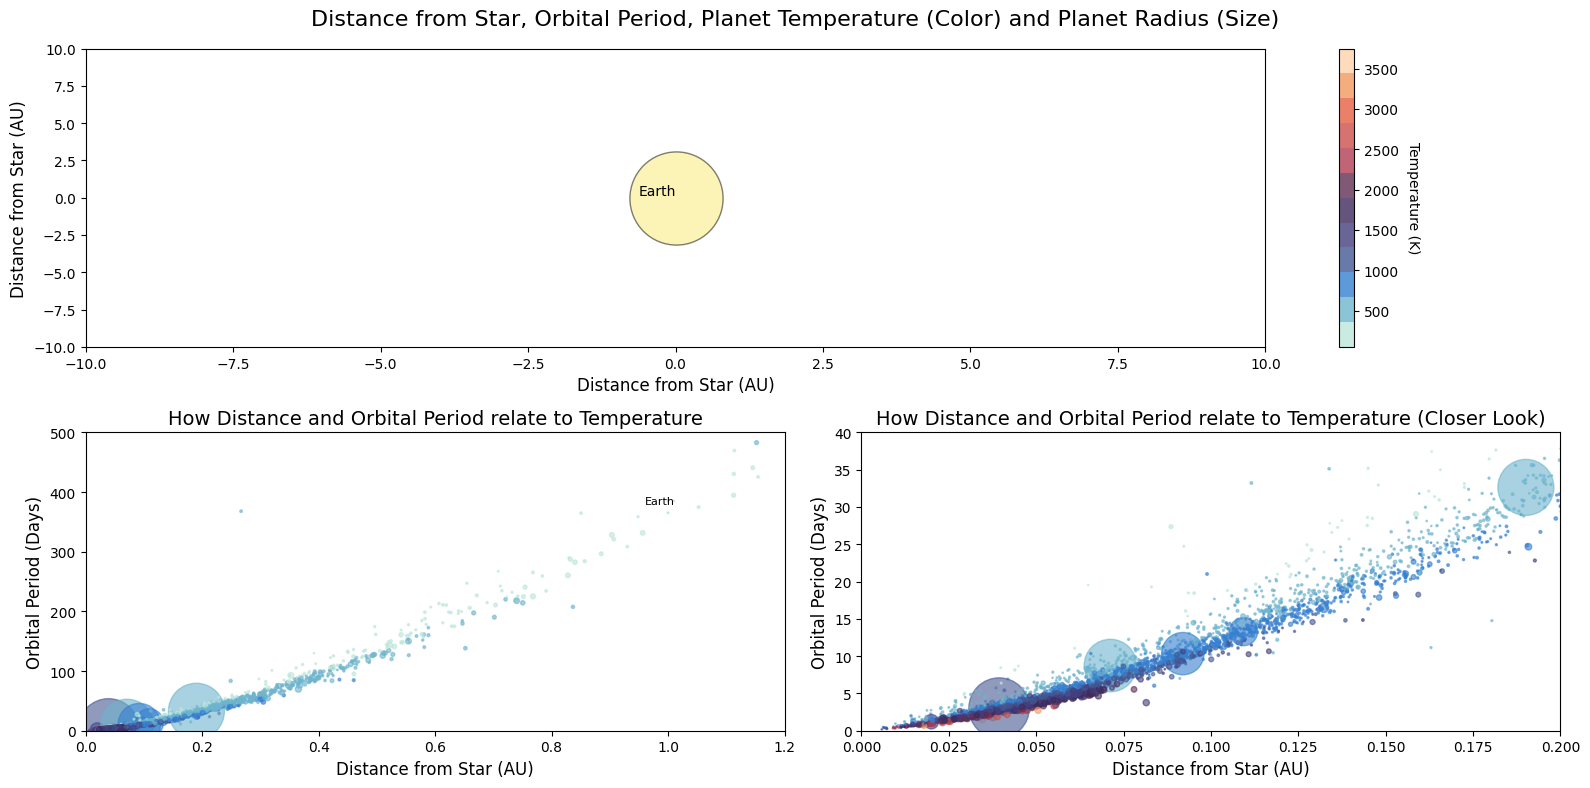

In [182]:
fig = plt.figure(figsize=(16, 8))
gridspan = fig.add_gridspec(2, 2)
 
ax1 = fig.add_subplot(gridspan[0, :])
ax2 = fig.add_subplot(gridspan[1, 0])
ax3 = fig.add_subplot(gridspan[1, 1])

ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.set_xlabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)
ax1.set_ylabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)
norm = Normalize(vmin=solar_exo_animation['pl_eqt'].min(), vmax=solar_exo_animation['pl_eqt'].max())
k_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap=COLOR_CMAP, alpha=0.8, norm=norm)
s_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap=COLOR_CMAP, norm=norm)
earth = ax1.scatter(x=[], y=[], s=50, c=[], cmap=COLOR_CMAP, edgecolors='black', norm=norm)
earth_text = ax1.text(0, 0, 'Earth', color='black', ha='right', va='bottom')
star = ax1.scatter(x=0, y=0, s=4500, color="#fbe86f", edgecolors='black', alpha=0.5)
cbar_kp = plt.colorbar(k_p, ax=ax1)
cbar_kp.set_label('Temperature (K)', rotation=270, labelpad=15)
def update(i):
    k_p.set_offsets(np.column_stack((x_positions[i % num_frames, :len(solar_exo_animation) - 8],
                                    y_positions[i % num_frames, :len(solar_exo_animation) - 8])))
    k_p.set_sizes(planet_sizes[i % num_frames, :len(solar_exo_animation) - 8])
    k_p.set_array(solar_exo_animation['pl_eqt'].iloc[:len(solar_exo_animation) - 8])
    s_p.set_offsets(np.column_stack((x_positions[i % num_frames, -8:-1],
                                    y_positions[i % num_frames, -8:-1])))
    s_p.set_sizes(planet_sizes[i % num_frames, -8:-1])
    s_p.set_array(solar_exo_animation['pl_eqt'].iloc[-8:-1])
    earth.set_offsets(np.column_stack((x_positions[i % num_frames, -1],
                                    y_positions[i % num_frames, -1])))
    earth.set_array([solar_exo_animation['pl_eqt'].iloc[-1]])
    earth_text.set_position((x_positions[i % num_frames, -1], y_positions[i % num_frames, -1]))
    return k_p, s_p, earth, earth_text

ax2.set_xlim(0, 1.2)
ax2.set_ylim(0, 500)
ax2.scatter(
    x=solar_exo_animation['pl_orbsmax'], 
    y=solar_exo_animation['pl_orbper'], 
    c=solar_exo_animation['pl_eqt'],
    s=solar_exo_animation['pl_rade'], 
    cmap=COLOR_CMAP, 
    alpha=0.6
)
ax2.annotate(
    'Earth', 
     xy=(earth_animation['pl_orbsmax'], earth_animation['pl_orbper']),
     xytext=(5, 5),
     textcoords='offset points',
     ha='right',
     va='bottom',
     fontsize=8,
     color='black'
)
ax2.set_xlabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)
ax2.set_ylabel('Orbital Period (Days)', fontsize=AXIS_TITLE_SIZE)
ax2.set_title('How Distance and Orbital Period relate to Temperature', fontsize=SUBTITLE_SIZE)

ax3.set_xlim(0, 0.2)
ax3.set_ylim(0, 40)
ax3.scatter(
    x=solar_exo_animation['pl_orbsmax'], 
    y=solar_exo_animation['pl_orbper'], 
    c=solar_exo_animation['pl_eqt'],
    s=solar_exo_animation['pl_rade'], 
    cmap=COLOR_CMAP, 
    alpha=0.6
)
ax3.set_xlabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)
ax3.set_ylabel('Orbital Period (Days)', fontsize=AXIS_TITLE_SIZE)
ax3.set_title('How Distance and Orbital Period relate to Temperature (Closer Look)', fontsize=SUBTITLE_SIZE)

fig.suptitle("Distance from Star, Orbital Period, Planet Temperature (Color) and Planet Radius (Size)", fontsize=TITLE_SIZE)

plt.tight_layout()
plt.show()
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=200, repeat=False)
ani.save(f"{PLOTS_SAVE_DIR}planets_orbiting_star_animation.gif", writer='pillow', fps=30)

![Alt Text](data/planets_orbiting_star_animation.gif)

# Which planets are Inhabitable?

In [56]:
# Habitable Zone Boundaries
def hab_zone_boundaries_lum(stellar_luminosity):
    """
    calculate inner and outer boundaries of the habitable zone based on stellar luminosity

    formula reference: https://www.planetarybiology.com/calculating_habitable_zone.html
    inner boundary: R_i=sqrt(L, i_c)
    outer boundary: R_o=sqrt(L, o_c)
    where:
    - L - star luminosity
    - i_c = 1.1 - inner zone coefficient
    - o_c = 0.53 - outer zone coefficient

    parameters:
    - stellar_luminosity: stellar luminosity in log(Solar)

    returns:
    - inner_boundary: inner boundary of the habitable zone in AU
    - outer_boundary: outer boundary of the habitable zone in AU
    """

    outer_coefficint = 0.53
    inner_coefficient = 1.1

    outer_boundary = np.sqrt(10 ** stellar_luminosity / outer_coefficint)
    inner_boundary = np.sqrt(10 ** stellar_luminosity / inner_coefficient)

    return outer_boundary, inner_boundary

def hab_remove_outliers(dataframe, window_size, column, cutoff_threshold):
    start = 0
    frames = len(dataframe)//window_size
    indecies = []
    for frame in range(frames):
        window_median = dataframe[column].iloc[start:start+window_size].median()
        for idx, row in dataframe.iloc[start:start+window_size].iterrows():
            if (abs(row[column]-window_median))/window_median > cutoff_threshold:
                indecies.append(idx)
        start += window_size
    for idx, row in dataframe.iloc[start:-1].iterrows():
        window_median = dataframe[column].iloc[start:-1].median()
        if (abs(row[column]-window_median))/window_median > cutoff_threshold:
            indecies.append(idx)

    return indecies

In [57]:
exoplanets[['hab_zone_inner', 'hab_zone_outer']] = exoplanets['st_lum'].apply(
    lambda lum: pd.Series(hab_zone_boundaries_lum(lum))
)
exoplanets_hab = exoplanets.copy()
exoplanets_hab = exoplanets_hab.dropna(subset=['hab_zone_inner', 'hab_zone_outer', 'st_mass'])
exoplanets_hab = exoplanets_hab.sort_values(by='st_mass')

outliers_indecies = hab_remove_outliers(exoplanets_hab, 200, 'hab_zone_inner', 0.2)
exoplanets_hab = exoplanets_hab.drop(outliers_indecies)
exoplanets_hab = exoplanets_hab.sort_values(by='st_mass')

outliers_hab = exoplanets_hab[
    (exoplanets_hab['pl_orbsmax'] > 10**0) & 
    (exoplanets_hab['pl_eqt'] > 10**3)
]
outliers_hab = outliers_hab[outliers_hab['pl_name'] != 'GSC 06214-00210 b']

solarplanets['hab_zone_inner'] = 0.9
solarplanets['hab_zone_outer'] = 1.53

exoplanets_hab_in = exoplanets_hab[(exoplanets_hab['pl_orbsmax'] < exoplanets_hab['hab_zone_inner']) & (exoplanets_hab['pl_orbsmax'] > exoplanets_hab['hab_zone_outer'])]
solarplanets_hab_in = solarplanets[(solarplanets['pl_orbsmax'] > solarplanets['hab_zone_inner']) & (solarplanets['pl_orbsmax'] < solarplanets['hab_zone_outer'])]

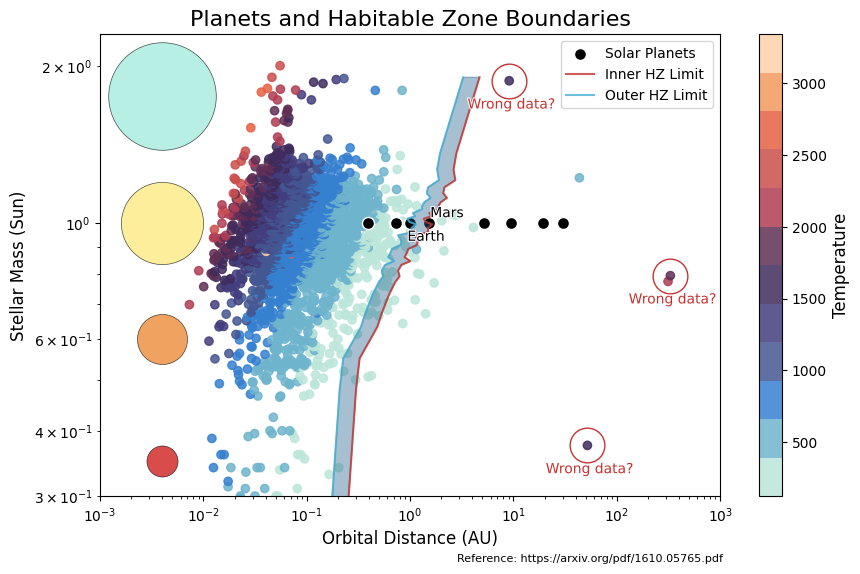

In [198]:
plt.figure(figsize=(10, 6))

scatter_exoplanets = plt.scatter(x=exoplanets_hab['pl_orbsmax'], y=exoplanets_hab['st_mass'], c=exoplanets_hab['pl_eqt'], alpha=0.85, cmap=COLOR_CMAP)
plt.scatter(x=solarplanets['pl_orbsmax'], y=solarplanets['st_mass'], label='Solar Planets', s=75, color='black', edgecolor='white', alpha=1)

plt.plot(exoplanets_hab['hab_zone_inner'][::81], exoplanets_hab['st_mass'][::81], label='Inner HZ Limit', color=PRIMARY_COLOR_END, alpha=0.8)
plt.plot(exoplanets_hab['hab_zone_outer'][::81], exoplanets_hab['st_mass'][::81], label='Outer HZ Limit', color=PRIMARY_COLOR_START, alpha=0.8)
inner_limit = exoplanets_hab['hab_zone_inner'][::81]
outer_limit = exoplanets_hab['hab_zone_outer'][::81]
st_mass = exoplanets_hab['st_mass'][::81]
plt.fill_betweenx(st_mass, inner_limit, outer_limit, color='#22628e', alpha=0.4)

planet_names = ['Earth', 'Mars']
planet_text_xys = [(25, -15), (25, 2)]
for planet_name, planet_text_xy in zip(planet_names, planet_text_xys):
    plt.annotate(
        planet_name, 
        xy=(solarplanets[solarplanets['pl_name']==planet_name]['pl_orbsmax'], solarplanets[solarplanets['pl_name']==planet_name]['st_mass']),
        xytext=planet_text_xy,
        textcoords='offset points',
        ha='right',
        va='bottom',
        fontsize=10,
        color='black',
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
)

star_x = 10**(-3)*4
star_y = [0.35, 0.6, 1, 1.75]
star_sizes = [500, 1300, 3500, 6000]
star_colors = ['#c90000', '#eb7c1c', '#fbe86f', '#9be9da']
for idx, _ in enumerate(star_y):
    plt.scatter(x=star_x, y=star_y[idx], s=star_sizes[idx], marker='o', color=star_colors[idx], edgecolors='black', linewidth=0.5, alpha=0.7)

outliers_x = outliers_hab['pl_orbsmax']
outliers_y = outliers_hab['st_mass']
for x, y in zip(outliers_x, outliers_y):
    plt.plot(x, y, marker='o', ms=25, mfc='none', mec=PRIMARY_COLOR_END)
    plt.annotate(
        'Wrong data?', (x, y), textcoords="offset points", xytext=(-30,-20), ha='left', 
        fontsize=10, color=PRIMARY_COLOR_END, path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
    )

plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-3), 10**3)
plt.ylim(0.3, 10**0+1.3)

cbar = plt.colorbar(scatter_exoplanets, orientation='vertical')
cbar.set_label('Temperature', fontsize=AXIS_TITLE_SIZE)
plt.title('Planets and Habitable Zone Boundaries', fontsize=TITLE_SIZE)
plt.xlabel('Orbital Distance (AU)', fontsize=AXIS_TITLE_SIZE)
plt.ylabel('Stellar Mass (Sun)', fontsize=AXIS_TITLE_SIZE)
plt.legend(loc='upper right')
reference_text = 'Reference: https://arxiv.org/pdf/1610.05765.pdf'
plt.figtext(0.615, 0, reference_text, wrap=True, horizontalalignment='center', fontsize=8)
plt.savefig(f"{PLOTS_SAVE_DIR}habitable_zone", bbox_inches='tight')
plt.show()

- **Inner Boundary** ("Runaway Greenhouse"): This is the distance from the star where the greenhouse effect becomes too strong making the surface temperature too hot for liquid water.
- **Outer Boundary** ("Maximum CO₂ Greenhouse"): Beyond this distance, the greenhouse effect is not sufficient to keep the surface temperature warm enough for liquid water to exist.

In [83]:
habitable_columns = [
    'pl_name', 'hostname', 
    'pl_rade', 'pl_eqt', 'pl_orbeccen',
    'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_logg', 'st_age', 'st_dens'
]
# pl_rade [Earth Radius], pl_eqt [K], pl_orbeccen,
# st_teff [K], st_rad [Sun Radius], st_mass [Solar Mass], st_lum [log10(Solar)], st_logg [log10(cm/s**2)], st_age [Gyr], st_dens [g/cm**3]
habitable = exoplanets_hab_in[habitable_columns]
habitable_exo = habitable.dropna()

sun_teff = 5778 # https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
sun_rad = 1
sun_mass = 1
sun_luminosity = 0
sun_logg = np.log10(27400) # https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
sun_age = 4.51 # https://ui.adsabs.harvard.edu/abs/1989ApJ...339.1156G/abstract#:~:text=The%20age%20of%20the%20sun,4.49%20%2B%20or%20%2D%200.04%20Gyr.
sun_dens = 1.408 # https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
earth_mars = solarplanets[(solarplanets['pl_name']=='Earth') | (solarplanets['pl_name']=='Mars')]
earth_mars['hostname'] = 'Sun'
earth_mars['st_teff'] = sun_teff
earth_mars['st_rad'] = sun_rad
earth_mars['st_lum'] = sun_luminosity
earth_mars['st_logg'] = sun_logg
earth_mars['st_age'] = sun_age
earth_mars['st_dens'] = sun_dens
habitable_solar = earth_mars[habitable_columns]

habitable_exo_solar = pd.concat([habitable_exo, habitable_solar], ignore_index=True)

In [432]:
def compute_squared_differences(df: pd.DataFrame, exclude_columns: list) -> pd.DataFrame:
    """
    Compute differences between each planet's values and Earth's values in the specified DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing information about planets.
    - exclude_columns (list): A list of column names to exclude from the difference computation.

    Returns:
    - pd.DataFrame: A new DataFrame containing the differences for selected columns compared to Earth.
    """
    df_diff = pd.DataFrame()
    earth_row = df[df['pl_name'] == "Earth"].iloc[0]
    columns_to_diff = [col for col in df.columns if col not in exclude_columns]
    df_diff[columns_to_diff] = (df[columns_to_diff].sub(earth_row[columns_to_diff]))**2
    return df_diff


def normalize_differences(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize the differences for each column in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the differences for each planet compared to Earth.

    Returns:
    - pd.DataFrame: DataFrame with normalized differences.
    """
    normalized_df_diff = (df - df.min()) / (df.max() - df.min())
    return normalized_df_diff


def find_closest_planet(df: pd.DataFrame, n: int):
    """
    Find the planet with the smallest sum of normalized differences.

    Parameters:
    - df (pd.DataFrame): DataFrame containing normalized differences for each planet.
    - n (int): Number of closest planets to find.

    Returns:
    - closest_planets_idxs: List with indexes of n planets with lowest sum of squared differences.
    """
    sums = df.sum(axis=1)[:-1]
    closest_planets_idxs = sums.nsmallest(n).index.tolist()
    return closest_planets_idxs, sums
    

In [435]:
habitable_diff = compute_squared_differences(habitable_exo_solar, ['pl_name', 'hostname'])
habitable_normalized = normalize_differences(habitable_diff)
habitable_resemble_idxs, difference = find_closest_planet(habitable_normalized, 6)
habitable_resemble = habitable_exo_solar.loc[habitable_resemble_idxs]
habitable_resemble['difference'] = difference
habitable_closest = exoplanets_hab_in.loc[[exoplanets_hab_in['sy_dist'].idxmin()]]

In [436]:
habitable_resemble

,pl_name,hostname,pl_rade,pl_eqt,pl_orbeccen,st_teff,st_rad,st_mass,st_lum,st_logg,st_age,st_dens,difference
12,Kepler-1554 b,Kepler-1554,2.844167,271.500000,0.000000,5299.000000,0.801111,0.852500,-0.393000,4.566250,4.680000,2.431357,0.594748
13,Kepler-553 c,Kepler-553,11.371429,235.600000,0.000000,5311.666667,0.888889,0.901250,-0.261000,4.493750,8.390000,1.064067,1.132832
9,Kepler-1544 b,Kepler-1544,1.776429,255.600000,0.000000,4839.600000,0.740000,0.757778,-0.582000,4.577778,3.120000,3.854688,1.229001
14,Kepler-22 b,Kepler-22,2.191111,264.142857,0.102857,5589.090909,0.912727,0.925000,-0.160667,4.477778,7.993333,4.264543,1.271461
11,Kepler-712 c,Kepler-712,4.540429,240.800000,0.000000,5132.700000,0.744000,0.805556,-0.484000,4.600000,2.005000,2.268214,1.290722
15,Mars,Sun,0.532019,226.000000,0.093500,5778.000000,1.000000,1.000000,0.000000,4.437751,4.510000,1.408000,1.294756


In [430]:
habitable_closest

,pl_name,hostname,disc_year,discoverymethod,sy_snum,sy_pnum,sy_mnum,pl_controv_flag,pl_orbper,pl_orbsmax,...,st_age,st_dens,st_vsin,ra,dec,sy_dist,sy_dist_log,kepler_confirmed,hab_zone_inner,hab_zone_outer
295,GJ 876 c,GJ 876,2000,Radial Velocity,1.0,4.0,0.0,0.0,30.193646,0.132647,...,1.775,10.8656,0.16,343.323974,-14.266596,4.67517,0.669797,False,0.155118,0.107672


GJ 876 c - https://exoplanets.nasa.gov/exoplanet-catalog/6554/gj-876-c/

# KMEANS

In [407]:
habitable_kmeans = habitable_exo_solar.drop('pl_name', axis=1).drop('hostname', axis=1)

X = habitable_kmeans.values

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(data=x_scaled, columns=habitable_kmeans.columns)

In [408]:
k_max = 9

# Elbow Method
wcss = []
for i in range(1, k_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Silhouette Method
k_values = range(2, k_max)
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Finding the K value with the maximum silhouette score
max_silhouette_index = np.argmax(silhouette_scores)
max_silhouette_k = k_values[max_silhouette_index]
max_silhouette_score = silhouette_scores[max_silhouette_index]

num_clusters = max_silhouette_k
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=42)
kmeans_clusters = kmeans.fit_predict(x_scaled)
earth_like_indexes = indexes = np.where(kmeans_clusters == 3)[0]

pca = PCA()
principal_components = pca.fit_transform(x_scaled)[:, :2]
explained_variance_ratio = pca.explained_variance_ratio_

cluster_centers = {i: {'num_points': 0, 'center': 0} for i in range(num_clusters)}
for sample in range(len(principal_components)):
    cluster = kmeans_clusters[sample]
    cluster_centers[cluster]['num_points'] += 1
    cluster_centers[cluster]['center'] += principal_components[sample]
for cluster in cluster_centers:
    cluster_centers[cluster]['center'] /= cluster_centers[cluster]['num_points']

pc_clusters = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_clusters['Cluster'] = kmeans_clusters
pc_clusters['Center'] = None
for idx, cluster in enumerate(kmeans_clusters):
    pc_clusters.loc[idx, 'Center'] = str(cluster_centers[cluster]['center'].tolist())

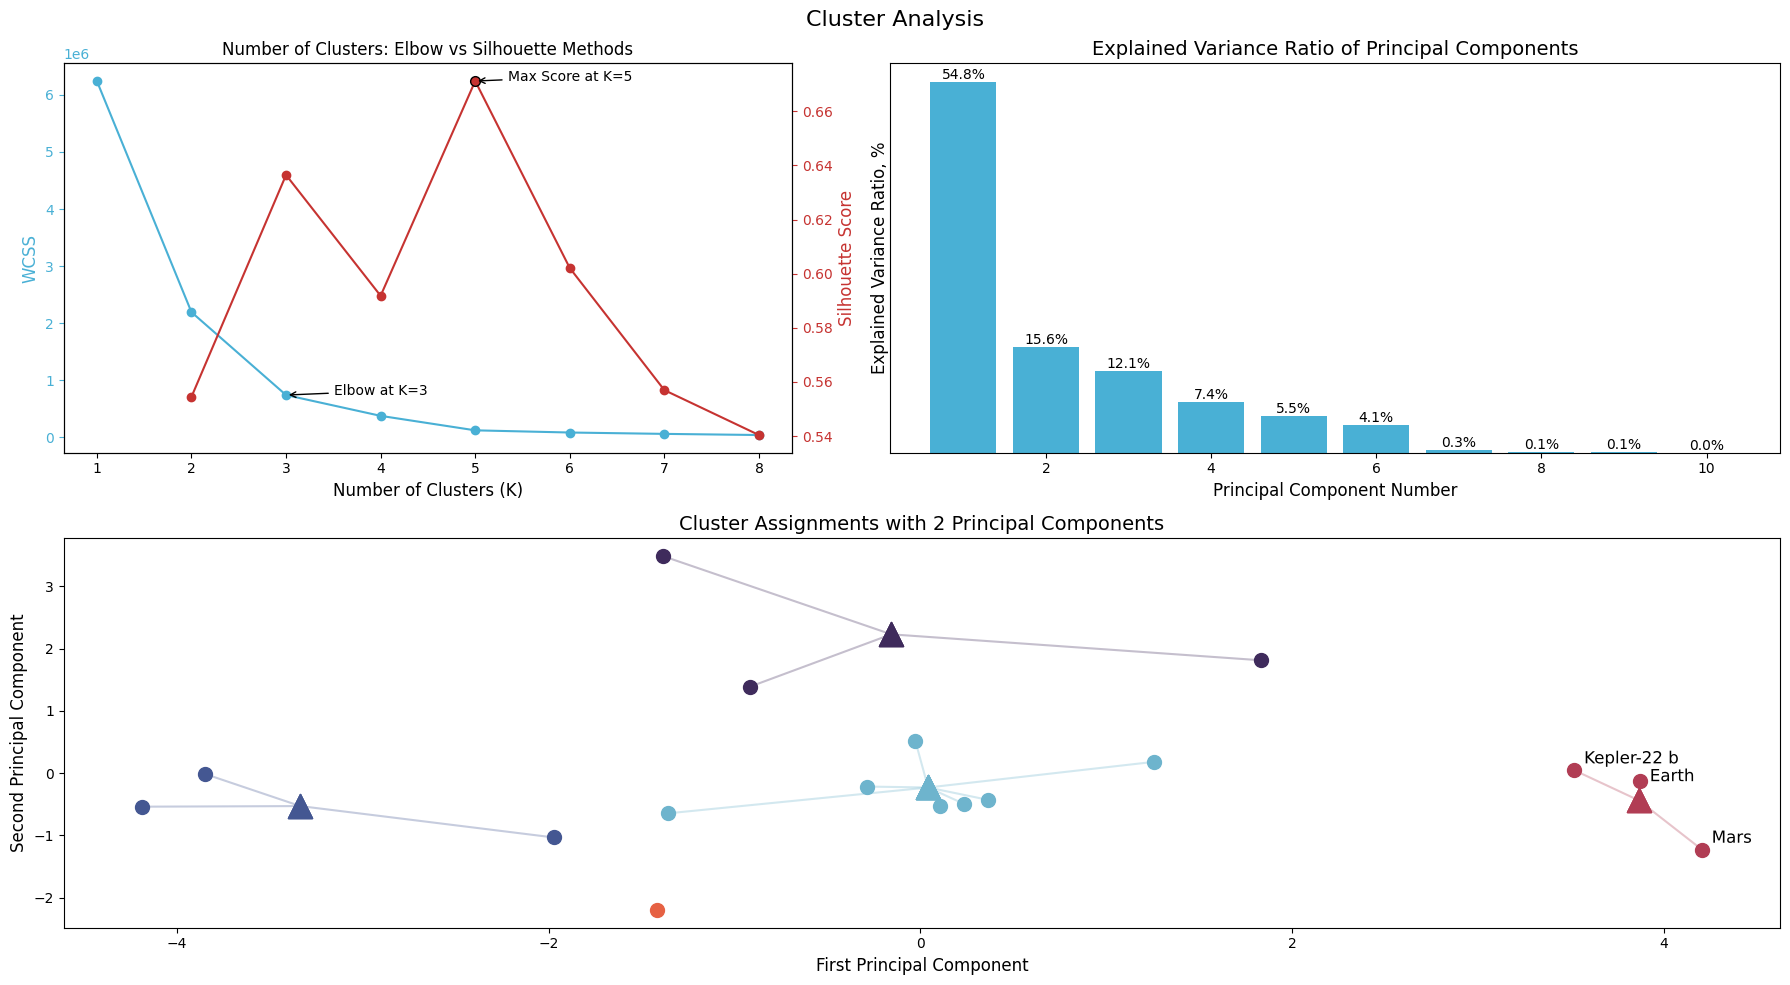

In [441]:
fig = plt.figure(figsize=(18, 10))
gridspan = fig.add_gridspec(2, 2, width_ratios=[4.5, 5.5])
ax1 = fig.add_subplot(gridspan[0, 0])
ax3 = fig.add_subplot(gridspan[0, 1])
ax4 = fig.add_subplot(gridspan[1, :])

# Elbow Method
ax1.plot(range(1, k_max), wcss, marker='o', color=PRIMARY_COLOR_START, label='WCSS')
ax1.set_xlabel('Number of Clusters (K)', fontsize=AXIS_TITLE_SIZE)
ax1.set_ylabel('WCSS', color=PRIMARY_COLOR_START, fontsize=AXIS_TITLE_SIZE)
ax1.tick_params('y', colors=PRIMARY_COLOR_START)
ax1.annotate(
    f'Elbow at K=3',
    xy=(3, wcss[2]),
    xytext=(4, wcss[2]),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    horizontalalignment='center',
    fontsize=10
)
ax1.set_title('Number of Clusters: Elbow vs Silhouette Methods')

# Silhouette Method
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, marker='o', color=PRIMARY_COLOR_END, label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color=PRIMARY_COLOR_END, fontsize=AXIS_TITLE_SIZE)
ax2.tick_params('y', colors=PRIMARY_COLOR_END)

ax2.plot(max_silhouette_k, max_silhouette_score, marker='o', markersize=7, color=PRIMARY_COLOR_END, fillstyle='none', markeredgecolor='black')
ax2.annotate(
    f'Max Score at K={max_silhouette_k}',
    xy=(max_silhouette_k, max_silhouette_score),
    xytext=(max_silhouette_k + 1, max_silhouette_score),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    horizontalalignment='center',
    fontsize=10
)

bars = ax3.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color=PRIMARY_COLOR_START)
for bar in bars:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1%}', ha='center', va='bottom', color='black', fontsize=10)
ax3.set_xlabel('Principal Component Number', fontsize=AXIS_TITLE_SIZE)
ax3.set_ylabel('Explained Variance Ratio, %', labelpad=-3, fontsize=AXIS_TITLE_SIZE)
ax3.set_yticks([])
ax3.set_title('Explained Variance Ratio of Principal Components', fontsize=SUBTITLE_SIZE)

cluster_colors = ['#6EB4CD', '#445792', '#3F2B5C', '#B13D54', '#E66143', '#FED2AA']
for sample in range(len(x_scaled)):
    cluster = cluster_centers[kmeans_clusters[sample]]
    ax4.scatter(principal_components[sample][0], principal_components[sample][1], color=cluster_colors[kmeans_clusters[sample]], s=100)
    if sample in earth_like_indexes:
        planet_name = habitable_exo_solar.loc[sample]['pl_name']
        xytext = (7,5)
        if planet_name=='Earth':
            xytext = (7,0)
        ax4.annotate(
            planet_name, 
            (principal_components[sample][0], principal_components[sample][1]), 
            textcoords="offset points",
            color='black',
            fontsize=12,
            xytext=xytext,
            path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
        )
    if cluster['num_points'] != 1:
        ax4.scatter(cluster['center'][0], cluster['center'][1], marker='^', c=cluster_colors[kmeans_clusters[sample]], s=300)

for idx, val in pc_clusters.iterrows():
    center = literal_eval(val['Center'])
    x = [val['PC1'], center[0]]
    y = [val['PC2'], center[1]]
    ax4.plot(x, y, c=cluster_colors[kmeans_clusters[idx]], alpha=0.3)

ax4.set_xlabel('First Principal Component', fontsize=AXIS_TITLE_SIZE)
ax4.set_ylabel('Second Principal Component', fontsize=AXIS_TITLE_SIZE)
ax4.set_title('Cluster Assignments with 2 Principal Components', fontsize=SUBTITLE_SIZE)

fig.suptitle("Cluster Analysis", fontsize=TITLE_SIZE)
plt.tight_layout()
plt.show()

kepler-1554 b: https://exoplanets.nasa.gov/exoplanet-catalog/2429/kepler-1554-b/
kepler-22 b: https://exoplanets.nasa.gov/exoplanet-catalog/1599/kepler-22b/